# DSCI 510 FINAL PROJECT
#### Name: Xiangyuan Chi
#### Database: OXY stock price; WTI crude oil price; Electric Vehicle Sales
#### Topic: relationship between stocks and their influences on EV sales

Q: What's the aim of this project?
--

1. Is there any (linear) relationship between wti crude oil price and oxy stock price?  (Notes 1)

2. Will the wti price or oxy price play an important role for Electric Vehicles sales?  (Notes 2)

3. Compare the two years EV_sales, shown in one table.


Q: What's the difficulty encountered?
--

1. Data Preparation: based on the different sources (some from webscrape, others from yfianance,the rest fetched via API key)
2. Data Combination: due to the variety of data, how to analyze and show it clearly in an appropriate way puts me in a spin
3. Data Visualization: different data property decides different plot methods, such as scatter plot, linear regression plot


Q: How to further expand the project?
--

1. Based on the web scrap code: make a little change to fetch data in different timeslot. For example, instead of getting daily wti price via url = 'https://api.eia.gov/series/?api_key=' + api_key +'&series_id='+'PET.RWTC.D', the series_id can ben replaced by 'PET.RWTC.M', which fetch the monthly wti price (See the appendix at the end of code)
2. For data prediction and machine learning, more data incorporated will be better for data training. Because of the scarcity in these datasets, the accuracy may be low and it is hard to find a more fitted model. More data will perform better.
3. The start_day and end_day for tickers are too short, so if it includes a longer time frame (3000 days), the correlation might be much more closer than over a shorter time frame.


Conclusion:
--

1. The relationship between wti crude oil price and oxy stock price is weak.

2. Neither wti price nor oxy price plays an important role for Electric Vehicles sales.


Notes
--
#### 1. WTI crude oil price is a international crude oil transaction benchmark, which should influence the oxy stock price. (OXY - Occidental Petroleum Corporation- is a company engaged in hydrocarbon exploration and petrochemical manufacturing)
#### 2. It is an intuitve that as the gosiline price goes higher, people are more willing to buy EVs which are fueled by electricity instead of gasoline.  
#### 3.Further analysis and explanation of conclusion can be found in the report

In [1]:
import pandas as pd
import csv
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statistics import mean
from scipy import stats

In [2]:
'''
ev_df = pd.read_csv('C:\\Users\\win10\\Desktop\\car_sales.csv',encoding='utf-8')
oxy_df = pd.read_csv('C:\\Users\\win10\\Desktop\\OXY_stock.csv',encoding='utf-8')
wti_df = pd.read_csv('C:\\Users\\win10\\Desktop\\wti_spot_price.csv',encoding='utf-8')
'''

"\nev_df = pd.read_csv('C:\\Users\\win10\\Desktop\\car_sales.csv',encoding='utf-8')\noxy_df = pd.read_csv('C:\\Users\\win10\\Desktop\\OXY_stock.csv',encoding='utf-8')\nwti_df = pd.read_csv('C:\\Users\\win10\\Desktop\\wti_spot_price.csv',encoding='utf-8')\n"

In [3]:
# Load Data
ev_df = pd.read_csv('car_sales.csv',encoding='utf-8')
oxy_df = pd.read_csv('OXY_stock.csv',encoding='utf-8')
wti_df = pd.read_csv('wti_spot_price.csv',encoding='utf-8')
wti_df = wti_df.drop('Unnamed: 0',axis=1)

In [36]:
wti_df.head(5)

,Date,Spot Price
0,2015-01-02,53.44
1,2015-01-09,48.77
2,2015-01-16,47.07
3,2015-01-23,46.46
4,2015-01-30,45.32


In [4]:
# Combine weekly oxy_close price with wti_price 
oxy_wti = pd.merge(oxy_df, wti_df, on="Date")
oxy_wti = oxy_wti.rename(columns={"Close": "OXY", "Spot Price": "WTI"})
oxy_wti.head(5) # oxy_wti = oxy_wti.set_index('Date')

,Date,OXY,WTI
0,2015-01-02,80.65,53.44
1,2015-01-09,77.54,48.77
2,2015-01-16,78.06,47.07
3,2015-01-23,78.85,46.46
4,2015-01-30,80.00,45.32


## Simple Regression Model

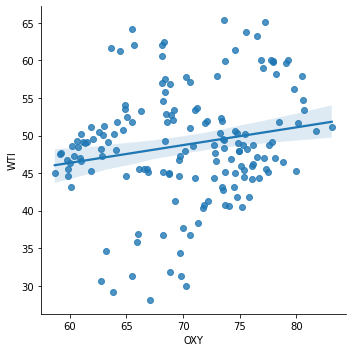

In [5]:
# Regression line between OXY and WTI
sns.lmplot(x='OXY', y='WTI', data=oxy_wti, fit_reg=True)

#### Even though OXY sounds to be closely related to WTI price, based on the plotted regression line above, it seems there is no significantly relationship.
#### Let's check their correlation in a numerical way.

In [6]:
oxy_wti.corr(method ='pearson') 

,OXY,WTI
OXY,1.000000,0.188519
WTI,0.188519,1.000000


#### correlation coefficent is only 0.188, which implies that there rarely exists relationship between OXY and WTI price

In [7]:
# Download two new stocks from yfinance, each of which is tightly related to the project
# CVX: a ticker belonged to GICS sector - Energy - which is the same as OXY
# ALB: a ticker belonged to GICS sector - Industry - which provides the raw material for electric vehicle

# How to use these two dataset:
# 1. Check the correlation among (OXY,WTI,CVX,ALB)
# 2. Find the top two most interrelated vairables (or called predictors) with either WTI or OXY for EV sales regression analysis

In [8]:
cvx = yf.download('CVX',start = '2015-01-02',end = '2017-12-30',interval='1d')
alb = yf.download('ALB',start = '2015-01-02',end = '2017-12-30',interval='1d' )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# Data preparation 
# Because of the different sources of the data, the first step is to unify their formats, including df.index, the datetime format

# CVX data
cvx_df = cvx['Close'].to_frame()
cvx_df = cvx_df.rename(columns = {'Close':'CVX'})

index = cvx_df.index
new_index = []
for i in index:
    i = i.strftime("%Y-%m-%d")
    new_index.append(i)
cvx_df = cvx_df.reset_index(drop = True)
cvx_df.insert(0,"Date",new_index,True)


# ALB data
alb_df = alb['Close'].to_frame()
alb_df = alb_df.rename(columns = {'Close':'ALB'})

alb_index = alb_df.index
alb_new_index = []

for i in alb_index:
    i = i.strftime("%Y-%m-%d")
    alb_new_index.append(i)
alb_df = alb_df.reset_index(drop = True)
alb_df.insert(0,"Date",alb_new_index,True)


data = pd.merge(oxy_wti,cvx_df,on = 'Date')
data = pd.merge(data,alb_df,on = 'Date')
data.head(5)


,Date,OXY,WTI,CVX,ALB
0,2015-01-02,80.65,53.44,112.580002,60.310001
1,2015-01-09,77.54,48.77,108.209999,59.020000
2,2015-01-16,78.06,47.07,105.120003,58.520000
3,2015-01-23,78.85,46.46,106.849998,56.840000
4,2015-01-30,80.00,45.32,102.529999,48.259998


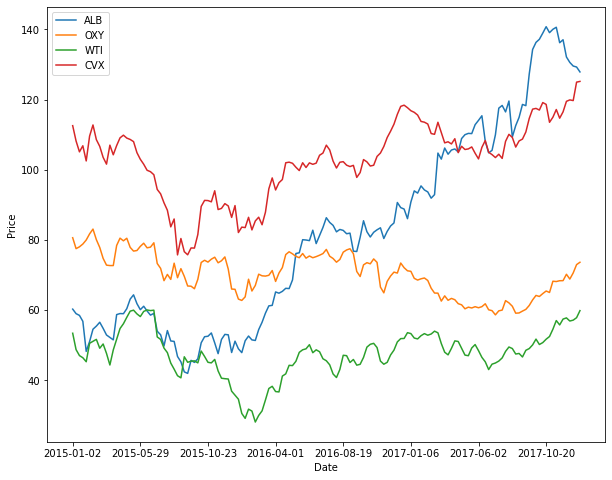

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

plt.plot(data['Date'],data['ALB'],label = 'ALB')
plt.plot(data['Date'],data['OXY'],label = 'OXY')
plt.plot(data['Date'],data['WTI'],label = 'WTI')
plt.plot(data['Date'],data['CVX'],label = 'CVX')
ax.set_xticks(data['Date'][::20])
ax.set_xticklabels(data['Date'][::20])
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

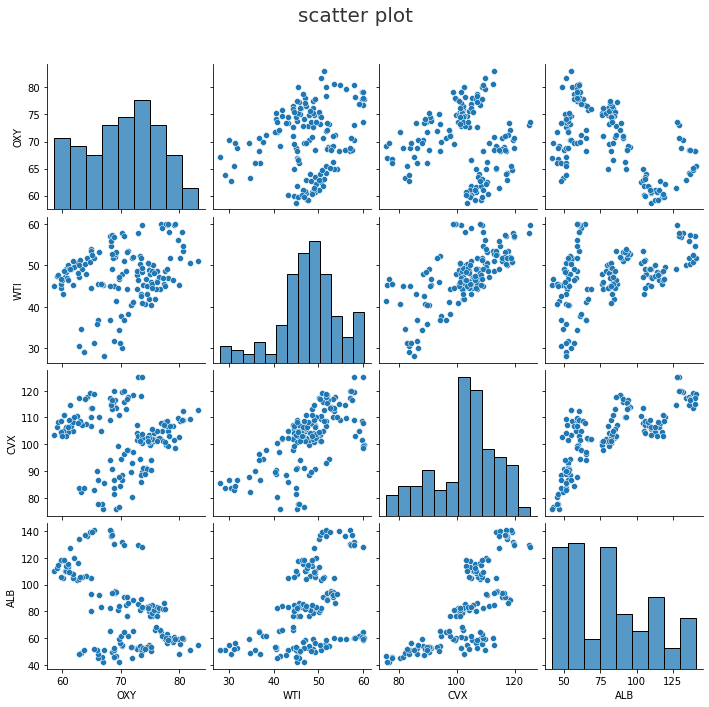

In [11]:
data_scatter = sns.pairplot(data,vars =['OXY','WTI','CVX','ALB'])
data_scatter.fig.suptitle("scatter plot",fontsize=20,alpha=0.8)
plt.subplots_adjust(top=0.9)

In [12]:
data.corr(method ='pearson') 

,OXY,WTI,CVX,ALB
OXY,1.000000,0.224514,-0.038744,-0.553070
WTI,0.224514,1.000000,0.666997,0.399048
CVX,-0.038744,0.666997,1.000000,0.740044
ALB,-0.553070,0.399048,0.740044,1.000000


### Correlation analysis
Correlation between 0.5 and 0.7 indicate variables moderately correlated.
Correlation between 0.3 and 0.5 indicate variables rarely correlated.
Based on the correlation report, we are encouraged to choose two pairs:(WTI,CVX)  & (OXY,ALB) for further regression model fitted, NOT inlcuded in this project.
In the following analysis, look back on __OXY__ and __WTI__.

## Moving Average Model: MA model
Moving averages for more days have a smoother plot, as they’re less reliable on daily fluctuations


In [13]:
ma_day = [10,20,50]
ma_oxy = oxy_wti[['Date','OXY']]
for day in ma_day:
    col = "MA_ %s days" % (str(day))
    ma_oxy[col] = ma_oxy['OXY'].rolling(window = day,center = False).mean()

ma_oxy.tail()
# Why check tail?
# pd.rolling() provides rolling window calculations, and hence before the first rolling window arrives, NA value shows in the oxy_wti.head()

,Date,OXY,MA_ 10 days,MA_ 20 days,MA_ 50 days
158,2018-02-23,68.32,72.870,70.3465,64.9578
159,2018-03-02,65.64,72.135,70.3920,65.0186
160,2018-03-09,63.67,71.136,70.3020,65.0102
161,2018-03-16,64.45,70.126,70.2720,65.0426
162,2018-03-23,65.49,69.022,70.1335,65.0852


<AxesSubplot:>

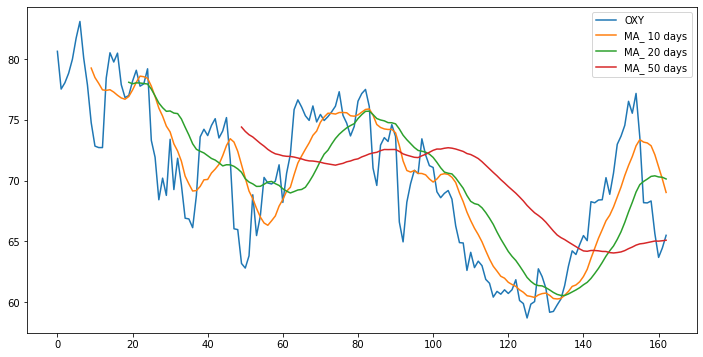

In [14]:
ma_oxy.plot(figsize = (12,6))

<AxesSubplot:>

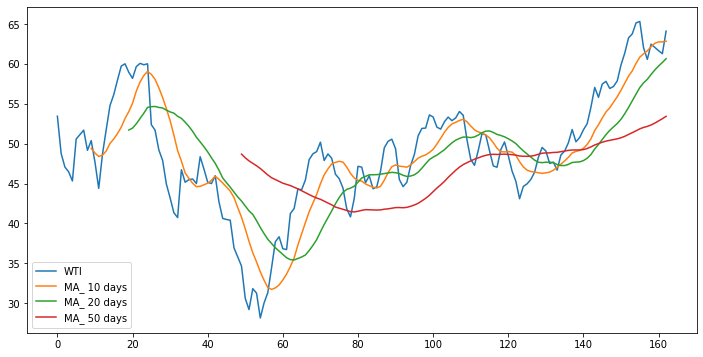

In [15]:
ma_wti = oxy_wti[['Date','WTI']]
for day in ma_day:
    col = "MA_ %s days" % (str(day))
    ma_wti[col] = ma_wti['WTI'].rolling(window = day,center = False).mean()

ma_wti.plot(figsize = (12,6))

### MA analysis
__MA__ model plot implies that with the same moving windows, wti price is more stable
This result corresponds to the correlation table, showing the relationship between wti and other variables is stronger than that of oxy
In this case, let's assume the regression model to predict EV sales will be more fitted, if it includes the predictor wti 

## Linear / Multiple Regression Model
Extract the 2017 stock data to fit model
Choose EV_sales 2017 as Y ; (OXY,WTI,ALB,CVX) as predictors X

In [16]:
start_index = oxy_wti[oxy_wti['Date']== '2017-01-06'].index
start_index = 100

end_index = oxy_wti[oxy_wti['Date']== '2017-12-29'].index
end_index = 150

In [17]:
oxy_wti_2017 = oxy_wti.iloc[100:151, :]

In [18]:
jan = oxy_wti_2017[:4] # dataframe
feb = oxy_wti_2017[4:8]
mar = oxy_wti_2017[8:13]
apr = oxy_wti_2017[13:16]
may = oxy_wti_2017[16:20]
jun = oxy_wti_2017[20:25]
jul = oxy_wti_2017[25:29]
aug = oxy_wti_2017[29:33]
sep = oxy_wti_2017[33:38]
octo = oxy_wti_2017[38:42]
nov = oxy_wti_2017[42:46]
dec = oxy_wti_2017[46:51]

monthly_data = [jan,feb,mar,apr,may,jun,jul,aug,sep,octo,nov,dec]
oxy_lst = []
wti_lst = []

for df in monthly_data:
    oxy_avg = round(mean(df['OXY'].values),2) # for a more concise format to truncate decimal to 2
    wti_avg = round(mean(df['WTI'].values),2)
    oxy_lst.append(oxy_avg)
    wti_lst.append(wti_avg)


In [19]:
reg_data = {'OXY':oxy_lst,'WTI':wti_lst}
month_index = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
reg_df = pd.DataFrame(data = reg_data, index = month_index)
reg_df

,OXY,WTI
JAN,69.42,52.49
FEB,67.20,53.36
MAR,63.55,49.70
APR,62.13,50.49
MAY,60.73,48.42
JUN,60.71,45.61
JUL,60.32,46.29
AUG,60.40,48.45
SEP,61.70,49.24
OCT,64.79,51.31


In [20]:
# Web Scrape for 2017 electric cars sales
html=requests.get('https://insideevs.com/news/344007/monthly-plug-in-ev-sales-scorecard-historical-charts/')
doc=html.text
soup = bs(doc, 'html.parser')

table = soup.find_all('table')
t_body = soup.find_all('tbody')[1]
first_table = table[1]

column_list = []
for element in first_table.find_all('tr')[0] :
    column_list.append(element.text)

column_list = list(filter(lambda val: val !=  ' ', column_list))


NAME_list = []
JAN_list = []
FEB_list = []
MAR_list = []
APR_list = []
MAY_list = []
JUN_list = []
JULY_list = []
AUG_list = []
SEP_list = []
OCT_list = []
NOV_list = []
DEC_list = []
TOTAL_list = []

for element in t_body.find_all('tr'):
    NAME_list.append(element.find_all('td')[0].text)
    JAN_list.append(element.find_all('td')[1].text)
    FEB_list.append(element.find_all('td')[2].text)
    MAR_list.append(element.find_all('td')[3].text)
    APR_list.append(element.find_all('td')[4].text)
    MAY_list.append(element.find_all('td')[5].text)
    JUN_list.append(element.find_all('td')[6].text)
    JULY_list.append(element.find_all('td')[7].text)
    AUG_list.append(element.find_all('td')[8].text)
    SEP_list.append(element.find_all('td')[9].text)
    OCT_list.append(element.find_all('td')[10].text)
    NOV_list.append(element.find_all('td')[11].text)
    DEC_list.append(element.find_all('td')[12].text)
    TOTAL_list.append(element.find_all('td')[13].text)
    
data = {}
car_2017 = pd.DataFrame(data)

body_list = [NAME_list,JAN_list,FEB_list,MAR_list,APR_list,MAY_list,JUN_list,JULY_list,AUG_list,SEP_list,OCT_list,NOV_list,DEC_list,TOTAL_list]

for i in range(len(column_list)):
    car_2017[column_list[i]] = body_list[i]

In [21]:
month_sale = car_2017[-3:].iloc[0:1, :]
month_sale[['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']]
month_sale = month_sale.drop(['2017 U.S. EV SALES','TOTAL'],axis=1)
month_sale = month_sale.T
month_sale = month_sale.rename(columns = {42:"SALES"})

In [22]:
# Convert format
convert_lst = []
for i in month_sale['SALES']:
    i = int(i.replace(',', ''))
    convert_lst.append(i)

# Combine data
sale_data = {'SALES': convert_lst}
month_index = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
month_sale = pd.DataFrame(data = sale_data, index = month_index)
reg_df = pd.concat([reg_df, month_sale], axis=1)


reg_df

,OXY,WTI,SALES
JAN,69.42,52.49,11005
FEB,67.20,53.36,12377
MAR,63.55,49.70,18541
APR,62.13,50.49,13365
MAY,60.73,48.42,16596
JUN,60.71,45.61,17046
JUL,60.32,46.29,15540
AUG,60.40,48.45,16514
SEP,61.70,49.24,21242
OCT,64.79,51.31,14315


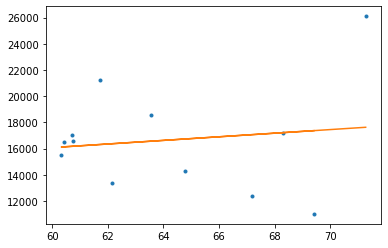

In [23]:
# Variable: OXY
model_OXY = sm.OLS.from_formula('SALES~OXY',data = reg_df)
model_OXY.fit()

OXY = reg_df['OXY']
SALES = reg_df['SALES']

# Simple Linear regression formula
# regr = intercept+ slope * x   
slope = stats.linregress(OXY,SALES)[0]
intercept = stats.linregress(OXY,SALES)[1]                            

regression_OXY = intercept + slope * OXY
plt.plot(OXY, SALES,'.',OXY,regression_OXY)
plt.show()


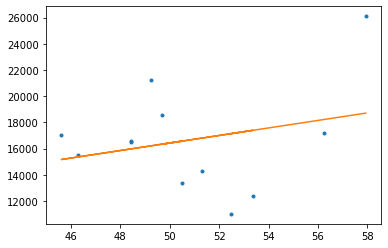

In [24]:
# Variable: WTI
model_WTI = sm.OLS.from_formula('SALES~WTI',data = reg_df)
model_WTI.fit()

WTI = reg_df['WTI']
SALES = reg_df['SALES']

# Simple Linear regression formula
# regr = intercept+ slope * x   
slope = stats.linregress(WTI,SALES)[0]
intercept = stats.linregress(WTI,SALES)[1]                            

regression_WTI = intercept + slope * WTI
plt.plot(WTI, SALES,'.',WTI,regression_WTI)
plt.show()


In [25]:
# Fit a multiple regression model
multi_reg=sm.OLS.from_formula('SALES~(OXY + WTI)',data = reg_df)
multi_reg.fit()
multi_reg.fit().summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SALES   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.7991
Date:                Wed, 11 May 2022   Prob (F-statistic):              0.479
Time:                        01:41:10   Log-Likelihood:                -115.26
No. Observations:                  12   AIC:                             236.5
Df Residuals:                       9   BIC:                             238.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.357e+04   2.11e+04      0.642      0.537   -3.42e+04    6.13e+04
OXY         -771.2780    828.669     -0.931      0.376   -2645.857    1103.301
WTI         1035.7962    871.378      1.189      0.265    -935.398    3006.991
==============================================================================
Omnibus:                        0.951   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.746
Skew:                           0.523   Prob(JB):                        0.689
Kurtosis:                       2.371   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Takeaway:
##### In general, R-squared shows how well the regression model fits the observed data.  In this multiplee regression model, R-squared = 0.151 means that only 15.1% of the data fit the regression model. Hence, it is NOT well-fitted.
##### Meanwhile, the std error is large and p-value is high, both of which implies that it is NOT well-fitted.

multi-index dataframe
--

Create a __multi-index__ dataframe to compare electric vehicles in different years.
A more direct way to compare the sales from the same model in different years.

In [26]:
# Web Scrape for 2018 electric cars sales (in a prettier way, which is better than the one I uploaded as .py--scrape )
html=requests.get('https://insideevs.com/news/344007/monthly-plug-in-ev-sales-scorecard-historical-charts/')
doc=html.text
soup = bs(doc, 'html.parser')

table = soup.find_all('table')
t_body = soup.find_all('tbody')[0]
first_table = table[0]

column_list = []
for element in first_table.find_all('tr')[0] :
    column_list.append(element.text)

column_list = list(filter(lambda val: val !=  ' ', column_list))


NAME_list = []
JAN_list = []
FEB_list = []
MAR_list = []
APR_list = []
MAY_list = []
JUN_list = []
JULY_list = []
AUG_list = []
SEP_list = []
OCT_list = []
NOV_list = []
DEC_list = []
TOTAL_list = []

for element in t_body.find_all('tr'):
    NAME_list.append(element.find_all('td')[0].text)
    JAN_list.append(element.find_all('td')[1].text)
    FEB_list.append(element.find_all('td')[2].text)
    MAR_list.append(element.find_all('td')[3].text)
    APR_list.append(element.find_all('td')[4].text)
    MAY_list.append(element.find_all('td')[5].text)
    JUN_list.append(element.find_all('td')[6].text)
    JULY_list.append(element.find_all('td')[7].text)
    AUG_list.append(element.find_all('td')[8].text)
    SEP_list.append(element.find_all('td')[9].text)
    OCT_list.append(element.find_all('td')[10].text)
    NOV_list.append(element.find_all('td')[11].text)
    DEC_list.append(element.find_all('td')[12].text)
    TOTAL_list.append(element.find_all('td')[13].text)
    
data = {}
car_2018 = pd.DataFrame(data)

body_list = [NAME_list,JAN_list,FEB_list,MAR_list,APR_list,MAY_list,JUN_list,JULY_list,AUG_list,SEP_list,OCT_list,NOV_list,DEC_list,TOTAL_list]

for i in range(len(column_list)):
    car_2018[column_list[i]] = body_list[i]
    

In [27]:
car_2018 = car_2018[:-3]
car_2018 = car_2018.iloc[:,:-1] # without the column 'TOTAL'
car_2018 = car_2018.rename(columns = {"2018 U.S. EV SALES":"BRAND"})
car_2018.head()

,BRAND,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,Tesla Model 3*,1875,2485,3820,3750,6000,5902,14250,17800,22250,17750,18650,25250
1,Toyota Prius Prime,1496,2050,2922,2626,2924,2237,1984,2071,2213,2001,2312,2759
2,Tesla Model X*,700,975,2825,1025,1450,2550,1325,2750,3975,1225,3200,4100
3,Tesla Model S*,800,1125,3375,1250,1520,2750,1200,2625,3750,1350,2750,3250
4,Honda Clarity PHEV*,604,911,1131,1129,1639,1495,1542,1462,1997,2025,1897,2770


In [28]:
car_2017 = car_2017[:-3]
car_2017 = car_2017.iloc[:,:-1] # without the column 'TOTAL'
car_2017 = car_2017.rename(columns = {"2017 U.S. EV SALES":"BRAND"})
car_2017.head()

,BRAND,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,Tesla Model S*,900,1750,3450,1125,1620,2350,1425,2150,4860,1120,1335,4975
1,Chevrolet Bolt EV,1162,952,978,1292,1566,1642,1971,2107,2632,2781,2987,3227
2,Tesla Model X*,750,800,2750,715,1730,2200,1650,1575,3120,850,1875,3300
3,Toyota Prius Prime,1366,1362,1618,1819,1908,1619,1645,1820,1899,1626,1834,2420
4,Chevrolet Volt,1611,1820,2132,1807,1817,1745,1518,1445,1453,1362,1702,1937


In [29]:
brands = pd.merge(car_2017,car_2018, on='BRAND')['BRAND']
brand_name = []
for i in brands.tolist():
    i=i.rstrip('\xa0')
    brand_name.append(i)
# len(brand_name) 15
# print(brand_name)
# ['Tesla Model S*', 'Tesla Model X*', 'Toyota Prius Prime', 'Nissan LEAF', 'Ford Fusion Energi', 'Ford C-Max Energi', 'BMW i3 (BEV + REx)', 'Fiat 500e**', 'Chrysler Pacifica Hybrid**', 'Volkswagen e-Golf', 'Ford Focus Electric', 'Mercedes B250e', 'smart ED', 'BMW i8', 'Mitsubishi Outlander PHEV']

In [30]:
columns = list(car_2017.columns)[1:] # ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
years = ["2017","2018"]
index = []

# pair brands with different years,format as :('Tesla Model S*', '2017'),('Tesla Model S*', '2018'),
for brand in brand_name:
    for i in years:
        tmp = []
        tmp.append(brand)
        tmp.append(i)
        index.append(tmp)

        
# Convert list_item to tuples
tuples_lst = []
for item in index:
    item = tuple(item)
    tuples_lst.append(item)
    
index_level = pd.MultiIndex.from_tuples(tuples_lst,names = ['brand','year'])

In [31]:
df = pd.concat([car_2017,car_2018])
result_tmp = []
for i in brands.tolist():
    tmp = df.loc[df["BRAND"] == i]
    res = tmp.values.tolist()
    result_tmp.append(res)

result_final = []
for j in result_tmp:
    result_final.append(j[0])
    result_final.append(j[1])

In [32]:
jan = []
feb = []
mar = []
apr = []
may = []
jun = []
jul = []
aug = []
sep = []
octo = []
nov = []
dec = []

for i in result_final:
    jan.append(i[1])
    feb.append(i[2])
    mar.append(i[3])
    apr.append(i[4])
    may.append(i[5])
    jun.append(i[6])
    jul.append(i[7])
    aug.append(i[8])
    sep.append(i[9])
    octo.append(i[10])
    nov.append(i[11])
    dec.append(i[12])

In [33]:
data={'JAN':jan,
      'FEB':feb,
      'MAR':mar,
      'APR':apr,
      'MAY':may,
      'JUN':jun,
      'JUL':jul,
      'AUG':aug,
      'SEP':sep,
      'OCT':octo,
      'NOV':nov,
      'DEC':dec}
car_df = pd.DataFrame(data,index = index_level)
car_df.head(10)

JAN   FEB   MAR   APR   MAY   JUN   JUL   AUG   SEP  \
brand              year                                                         
Tesla Model S*     2017   900  1750  3450  1125  1620  2350  1425  2150  4860   
                   2018   800  1125  3375  1250  1520  2750  1200  2625  3750   
Tesla Model X*     2017   750   800  2750   715  1730  2200  1650  1575  3120   
                   2018   700   975  2825  1025  1450  2550  1325  2750  3975   
Toyota Prius Prime 2017  1366  1362  1618  1819  1908  1619  1645  1820  1899   
                   2018  1496  2050  2922  2626  2924  2237  1984  2071  2213   
Nissan LEAF        2017   772  1037  1478  1063  1392  1506  1283  1154  1055   
                   2018   150   895  1500  1171  1576  1367  1149  1315  1563   
Ford Fusion Energi 2017   606   837  1002   905  1000   707   703   762   763   
                   2018   640   794   782   742   740   604   522   396   480   

                          OCT   NOV   DEC  
brand              year                    
Tesla Model S*     2017  1120  1335  4975  
                   2018  1350  2750  3250  
Tesla Model X*     2017   850  1875  3300  
                   2018  1225  3200  4100  
Toyota Prius Prime 2017  1626  1834  2420  
                   2018  2001  2312  2759  
Nissan LEAF        2017   213   175   102  
                   2018  1234  1128  1667  
Ford Fusion Energi 2017   741   731   875  
                   2018   453  1131   790

## Appendix
#### Further exploration of web_scrape

In [34]:
# Collect WTI monthly for EV mmonthly sales:
api_key ='vT2MbTCiEVzdJdsxQe1VVKxVBsmwrgbJroVhrDxc'
url = 'https://api.eia.gov/series/?api_key=' + api_key +'&series_id='+'PET.RWTC.M'
r=requests.get(url)
data=r.json()
oil_price=data['series'][0]['data']


result = []
date_lst = []
price_lst = []

for i in oil_price:
    if '201612'<i[0]<'201901':
        result.append(i)
result.sort(key=lambda x: x[0])

for i in result:
    date=datetime.strptime(i[0], '%Y%m')
    date=date.strftime('%Y-%m')
    date_lst.append(date)

for i in result:
    price = i[1]
    price_lst.append(price)

d={'Date':date_lst,
      'WTI': price_lst}
result_df = pd.DataFrame(data=d)

result_df.head(5)

,Date,WTI
0,2017-01,52.50
1,2017-02,53.47
2,2017-03,49.33
3,2017-04,51.06
4,2017-05,48.48
